In [1]:
import os
import shutil
import random
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import matplotlib.pyplot as plt

In [3]:
print(tf.__version__)

2.16.1


In [7]:
# Define parameters
batch_size = 32
img_height = 224
img_width = 224
data_dir = '/kaggle/input/ct-kidney-dataset-normal-cyst-tumor-and-stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone'
num_files = 3500

In [8]:
# Load datasets with data augmentation
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [9]:

train = tf.keras.utils.image_dataset_from_directory(data_dir, image_size=(img_height, img_width),
                                                     validation_split=0.1, subset='training', seed=123,
                                                     batch_size=batch_size)

val = tf.keras.utils.image_dataset_from_directory(data_dir, image_size=(img_height, img_width),
                                                   validation_split=0.2, subset='validation', seed=123,
                                                   batch_size=batch_size)


Found 12446 files belonging to 4 classes.
Using 11202 files for training.
Found 12446 files belonging to 4 classes.
Using 2489 files for validation.


In [10]:
label_to_class_name = dict(zip(range(len(train.class_names)), train.class_names))
label_to_class_name

{0: 'Cyst', 1: 'Normal', 2: 'Stone', 3: 'Tumor'}

In [11]:
for image_batch, labels_batch in train:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32,)


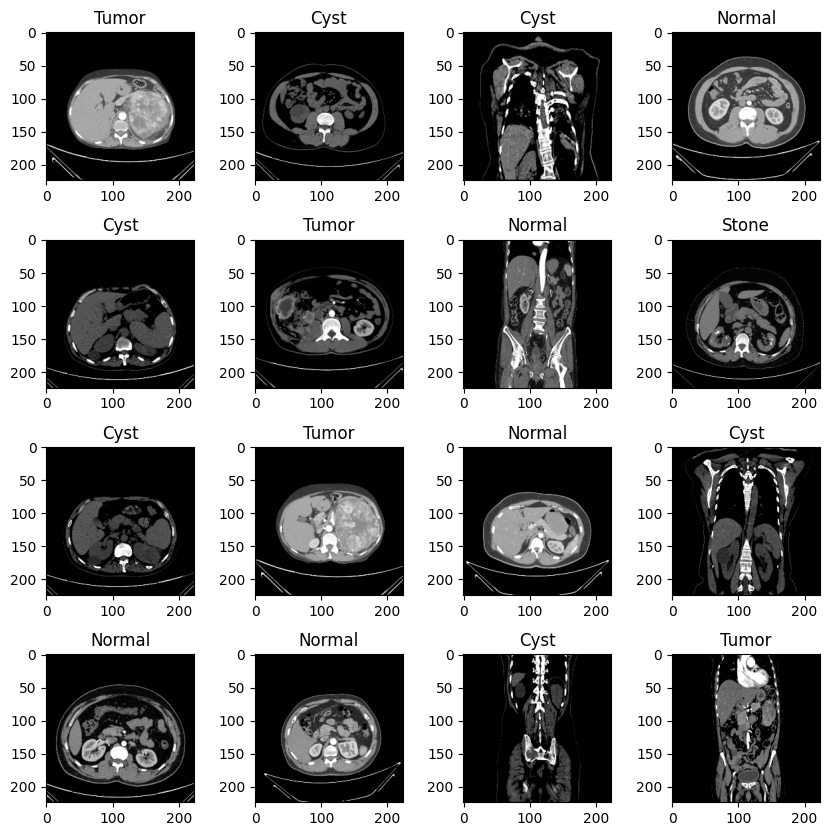

In [12]:
data_iterator = train.as_numpy_iterator()
batch = data_iterator.next()
fig, ax = plt.subplots(nrows=4, ncols=4, figsize=(10, 10))
for i in range(4):  
    for j in range(4):  
        index = i * 4 + j  
        ax[i, j].imshow(batch[0][index].astype(int))
        ax[i, j].set_title(label_to_class_name[batch[1][index]])
plt.subplots_adjust(wspace=0.4, hspace=0.4)
plt.show()

In [13]:
def augment_image(image):
    # Convert image to float32 if it's not already
    image = tf.image.convert_image_dtype(image, tf.float32)
    
    # Apply random transformations
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, max_delta=0.1)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    
    # Optionally resize or crop the image
    image = tf.image.resize_with_crop_or_pad(image, target_height=224, target_width=224)
    
    return image


In [14]:
# Apply the transformations to the train dataset
train = train.map(lambda x, y: (augment_image(x), y))

# Normalize validation dataset
val = val.map(lambda x, y: (tf.image.convert_image_dtype(x, tf.float32), y))

In [15]:
AUTOTUNE = tf.data.AUTOTUNE

train = train.cache().prefetch(buffer_size=AUTOTUNE)
val = val.cache().prefetch(buffer_size=AUTOTUNE)

# Resnet_model for kidney disease diagnosis and classification

In [16]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


In [17]:
print(tf.__version__)

2.16.1


In [19]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam

input_shape = (224, 224, 3)
resnet_model = ResNet50(input_shape=input_shape, weights='imagenet', include_top=False)

# Freeze more layers to start with
for layer in resnet_model.layers[:140]:
    layer.trainable = False

x = GlobalAveragePooling2D()(resnet_model.output)
x = Dense(512, activation='relu', kernel_regularizer=l2(1e-3))(x)  # Increase regularization
x = BatchNormalization()(x)  # Add Batch Normalization
x = Dropout(0.6)(x)  # Increase Dropout rate
output = Dense(4, activation='softmax')(x)

resnet_net = Model(inputs=resnet_model.input, outputs=output)


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [20]:
# Use a smaller learning rate and apply gradient clipping
optimizer = Adam(learning_rate=1e-4, clipvalue=1.0)
resnet_net.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [21]:
resnet_model.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 14,978,048 (57.14 MB)

 Non-trainable params: 8,609,664 (32.84 MB)

In [22]:
# Callbacks for learning rate adjustment and early stopping
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


In [23]:
history = resnet_net.fit(
    train, 
    epochs=10, 
    validation_data=val, 
    callbacks=[reduce_lr, early_stopping]
)


Epoch 1/10


I0000 00:00:1726268872.280864     135 service.cc:145] XLA service 0x7ec88c005030 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1726268872.280927     135 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1726268872.280933     135 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


  1/351 ━━━━━━━━━━━━━━━━━━━━ 2:33:14 26s/step - accuracy: 0.3125 - loss: 2.9208

I0000 00:00:1726268885.425614     135 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


351/351 ━━━━━━━━━━━━━━━━━━━━ 103s 219ms/step - accuracy: 0.7572 - loss: 1.5632 - val_accuracy: 0.9835 - val_loss: 0.8526 - learning_rate: 1.0000e-04
Epoch 2/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 48s 136ms/step - accuracy: 0.9698 - loss: 0.8814 - val_accuracy: 0.9964 - val_loss: 0.7756 - learning_rate: 1.0000e-04
Epoch 3/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 47s 135ms/step - accuracy: 0.9911 - loss: 0.7841 - val_accuracy: 0.9960 - val_loss: 0.7448 - learning_rate: 1.0000e-04
Epoch 4/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 48s 136ms/step - accuracy: 0.9912 - loss: 0.7501 - val_accuracy: 0.9867 - val_loss: 0.7314 - learning_rate: 1.0000e-04
Epoch 5/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 47s 135ms/step - accuracy: 0.9979 - loss: 0.6823 - val_accuracy: 0.9976 - val_loss: 0.6440 - learning_rate: 1.0000e-04
Epoch 6/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 47s 135ms/step - accuracy: 0.9956 - loss: 0.6352 - val_accuracy: 0.9996 - val_loss: 0.5883 - learning_rate: 1.0000e-04
Epoch 7/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 47s 135ms/step -

In [24]:
# Save the model after initial training
resnet_net.save('resnet_kidney_model.h5')

In [76]:
import pickle
from sklearn.metrics import confusion_matrix
import tensorflow as tf
import numpy as np


predictions = resnet_net.predict(train)

true_labels = np.concatenate([y for x, y in train], axis=0)

cm = confusion_matrix(true_labels, np.argmax(predictions, axis=1))

with open('ResNet_confusion_matrix.pkl', 'wb') as f:
    pickle.dump(cm, f)


351/351 ━━━━━━━━━━━━━━━━━━━━ 26s 75ms/step


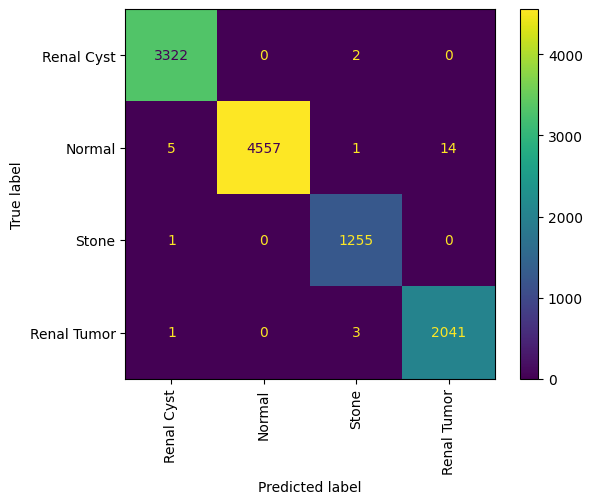

In [77]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# Load the saved confusion matrix
with open('ResNet_confusion_matrix.pkl', 'rb') as f:
    cm = pickle.load(f)

# Define class names (assuming you have them)
class_names = ['Renal Cyst', 'Normal', 'Stone', 'Renal Tumor']   # Replace with your actual class names
# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='viridis', xticks_rotation='vertical', values_format='d')

# Show the confusion matrix plot
plt.show()


In [78]:
from sklearn.metrics import accuracy_score, f1_score
# Calculate accuracy
accuracy = accuracy_score(true_labels, np.argmax(predictions, axis=1))
print(f'Accuracy: {accuracy:.4f}')

# Calculate F1 score (assuming you want the macro average)
f1 = f1_score(true_labels, np.argmax(predictions, axis=1), average='macro')
print(f'F1 Score (Macro): {f1:.4f}')


Accuracy: 0.9976
F1 Score (Macro): 0.9973


In [79]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

In [80]:
class_labels = {0: 'Renal Cyst', 1: 'Normal', 2: 'Stone', 3: 'Tumor'}

In [93]:

def predict_image(img_path, model, class_labels):
    """
    Predict the class of a single image using the trained model.
    
    Args:
    img_path (str): Path to the image file.
    model (tf.keras.Model): Trained Keras model for prediction.
    class_labels (dict): Mapping from class indices to class labels.
    
    Returns:
    prediction: The predicted class for the input image.
    """

    # Make predictions
    predictions = model.predict(img_path)
    
    # Get the predicted class index
    predicted_class_idx = np.argmax(predictions, axis=1)[0]
    
    # Map the predicted class index to the actual class label
    predicted_class_label = class_labels[predicted_class_idx]
    
    # Display the image with the predicted class label
    img = image.load_img(img_path)
    plt.imshow(img)
    plt.title(f"Predicted: {predicted_class_label}")
    plt.axis('off')
    plt.show()
    
    return predicted_class_label


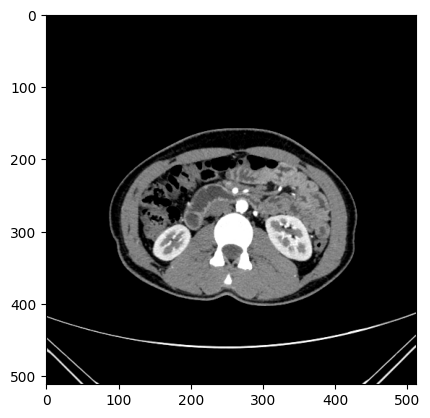

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


'Normal'

In [101]:
import cv2
img = cv2.imread('/kaggle/input/ct-kidney-dataset-normal-cyst-tumor-and-stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Normal/Normal- (1174).jpg')
plt.imshow(img)
plt.show()
resize = tf.image.resize(img, (224,224))
yhat = resnet_net.predict(np.expand_dims(resize/255, 0))
max_index = np.argmax(yhat)
label_to_class_name[max_index]

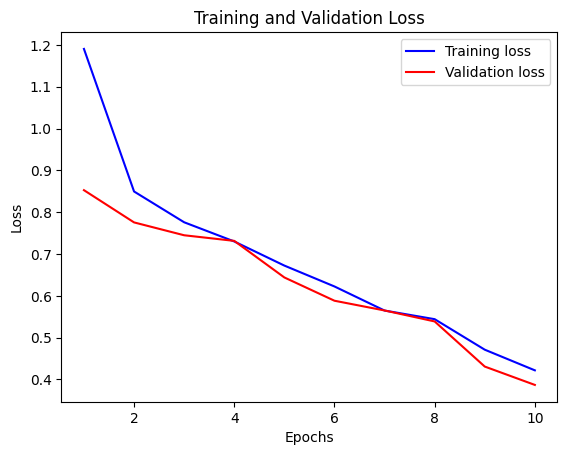

In [102]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss)+1)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

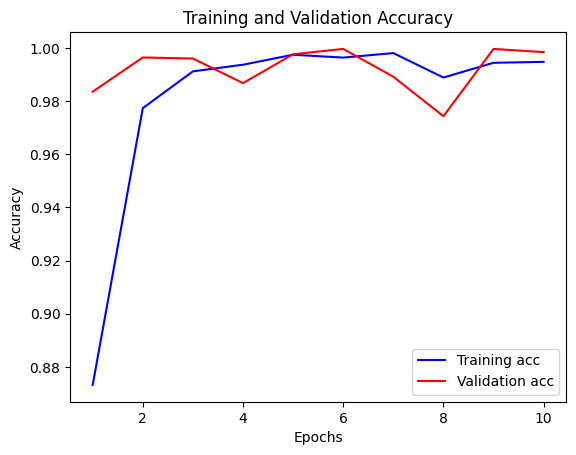

In [103]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()